# Classification Part 2: SVMs

ISLP 도서 참고 노트북 https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch09-svm-lab.ipynb

이 실습에서는 `sklearn.svm` 라이브러리를 사용하여 서포트 벡터 분류기와 서포트 벡터 머신을 시연합니다.

일반적으로 사용하는 라이브러리들을 몇 가지 임포트합니다.

In [ ]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table

또한 이 실습에 필요한 새로운 임포트들을 모아둡니다.

In [ ]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay

`RocCurveDisplay.from_estimator()` 함수를 사용하여 여러 ROC 플롯을 생성할 것이며, `roc_curve` 라는 약칭을 사용합니다.

In [ ]:
roc_curve = RocCurveDisplay.from_estimator  # shorthand

## Support Vector Classifier (서포트 벡터 분류기)

이제 `sklearn`의 `SupportVectorClassifier()` 함수(줄여서 `SVC()`)를 사용하여 주어진 파라미터 `C` 값에 대한 서포트 벡터 분류기를 적합시킵니다. `C` 인수는 마진 위반에 대한 비용을 지정할 수 있게 해줍니다. `cost` 인수가 작으면 마진이 넓어지고 많은 서포트 벡터가 마진 위에 있거나 마진을 위반하게 됩니다. `C` 인수가 크면 마진이 좁아지고 마진 위에 있거나 마진을 위반하는 서포트 벡터가 거의 없습니다.

여기서는 결과적인 결정 경계를 플롯할 수 있도록 2차원 예제에서 `SVC()`의 사용법을 보여줍니다. 먼저 두 클래스에 속하는 관측치를 생성하고 클래스가 선형적으로 분리 가능한지 확인하는 것으로 시작합니다.

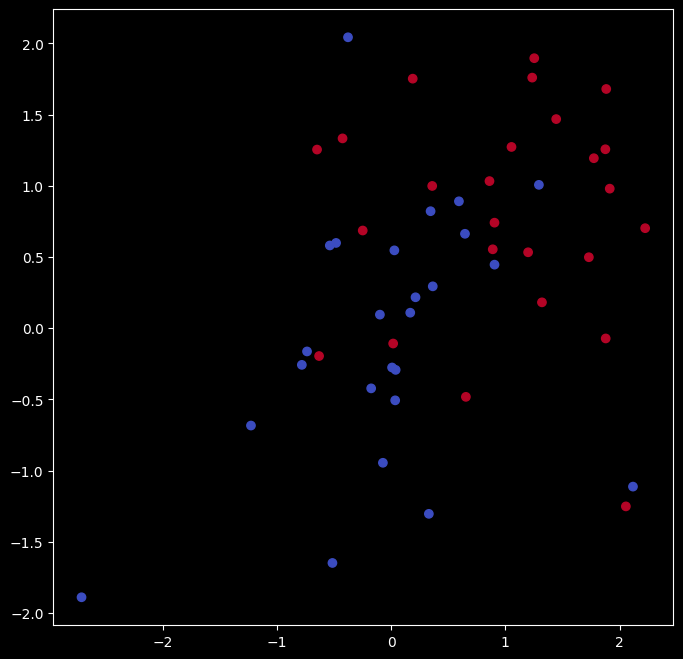

In [ ]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1] * 25 + [1] * 25)
X[y == 1] += 1
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm)

그렇지 않습니다. 이제 분류기를 적합시킵니다.

In [ ]:
svm_linear = SVC(C=10, kernel="linear")
svm_linear.fit(X, y)

,C,10
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


두 개의 특성을 가진 서포트 벡터 분류기는 결정 함수의 값을 플롯하여 시각화할 수 있습니다. `ISLP` 패키지에 이를 위한 함수를 포함시켰습니다 (`sklearn` 문서의 유사한 예제에서 영감을 받았습니다).

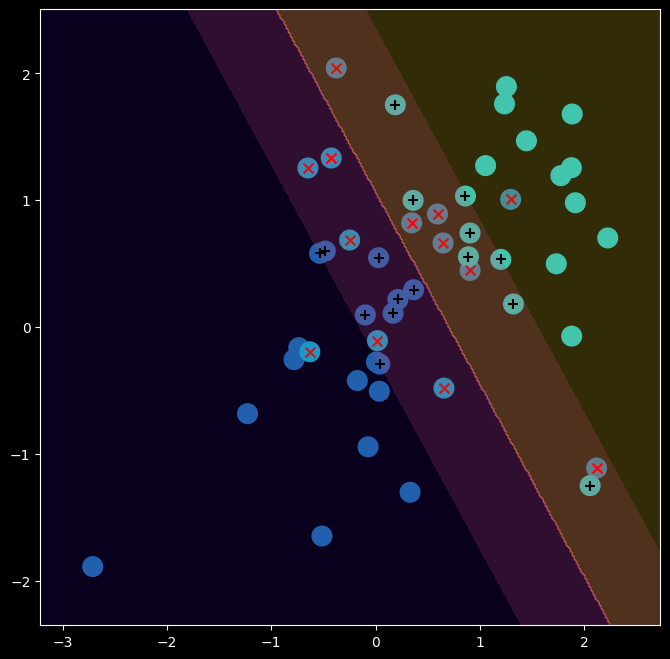

In [ ]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_linear, ax=ax)

두 클래스 사이의 결정 경계는 선형입니다 (kernel='linear' 인수를 사용했기 때문입니다). 서포트 벡터는 `+`로 표시되고 나머지 관측치는 원으로 플롯됩니다.

대신 더 작은 비용 파라미터 값을 사용하면 어떻게 될까요?

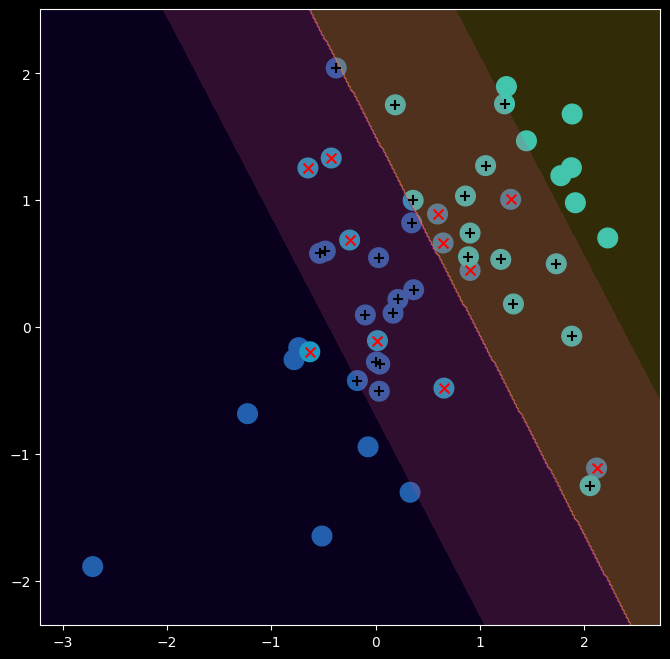

In [ ]:
svm_linear_small = SVC(C=0.1, kernel="linear")
svm_linear_small.fit(X, y)
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_linear_small, ax=ax)

비용 파라미터 값이 작을수록 마진이 더 넓어지기 때문에 더 많은 수의 서포트 벡터를 얻게 됩니다. 선형 커널의 경우, 다음과 같이 선형 결정 경계의 계수를 추출할 수 있습니다:

In [ ]:
svm_linear.coef_

array([[1.17303943, 0.77348227]])

서포트 벡터 머신은 `sklearn`의 추정기이므로, 일반적인 메커니즘을 사용하여 튜닝할 수 있습니다.

In [ ]:
kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(
    svm_linear,
    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
    refit=True,
    cv=kfold,
    scoring="accuracy",
)
grid.fit(X, y)
grid.best_params_

{'C': 1}

`grid.cv_results_`에서 각 모델에 대한 교차 검증 오차에 쉽게 접근할 수 있습니다. 이것은 많은 세부 정보를 출력하므로 정확도 결과만 추출합니다.

In [ ]:
grid.cv_results_[("mean_test_score")]

array([0.46, 0.46, 0.72, 0.74, 0.74, 0.74, 0.74])

`C=1`일 때 0.74로 가장 높은 교차 검증 정확도를 보이지만, 여러 `C` 값에 대해 정확도가 동일합니다. `grid.best_estimator_` 분류기는 테스트 관측치 집합의 클래스 레이블을 예측하는 데 사용할 수 있습니다. 테스트 데이터 세트를 생성해 보겠습니다.

In [ ]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1] * 10 + [1] * 10)
X_test[y_test == 1] += 1

이제 이 테스트 관측치의 클래스 레이블을 예측합니다. 여기서는 예측을 위해 교차 검증으로 선택된 최적의 모델을 사용합니다.

In [ ]:
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


따라서 이 `C` 값을 사용하면 테스트 관측치의 70%가 올바르게 분류됩니다. 대신 `C=0.001`을 사용했다면 어땠을까요?

In [ ]:
svm_ = SVC(C=0.001, kernel="linear").fit(X, y)
y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,2,0
1,8,10


이 경우 테스트 관측치의 60%가 올바르게 분류됩니다.

이제 두 클래스가 선형적으로 분리 가능한 상황을 고려해 보겠습니다. 그러면 `SVC()` 추정기를 사용하여 최적의 분리 초평면을 찾을 수 있습니다. 먼저 시뮬레이션된 데이터에서 두 클래스를 더 분리하여 선형적으로 분리 가능하도록 만듭니다:

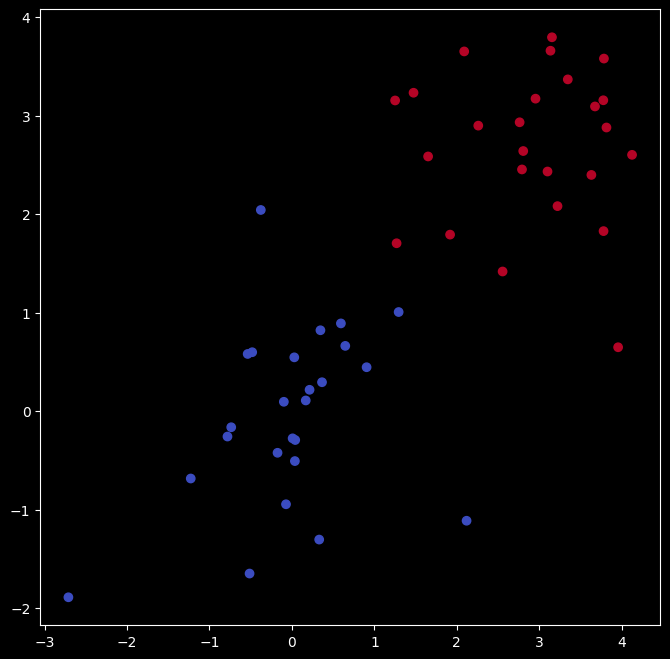

In [ ]:
X[y == 1] += 1.9
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm)

이제 관측치들은 겨우 선형적으로 분리 가능합니다.

In [ ]:
svm_ = SVC(C=1e5, kernel="linear").fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


관측치가 잘못 분류되지 않도록 매우 큰 `C` 값을 사용하여 서포트 벡터 분류기를 적합시키고 결과 초평면을 플롯합니다.

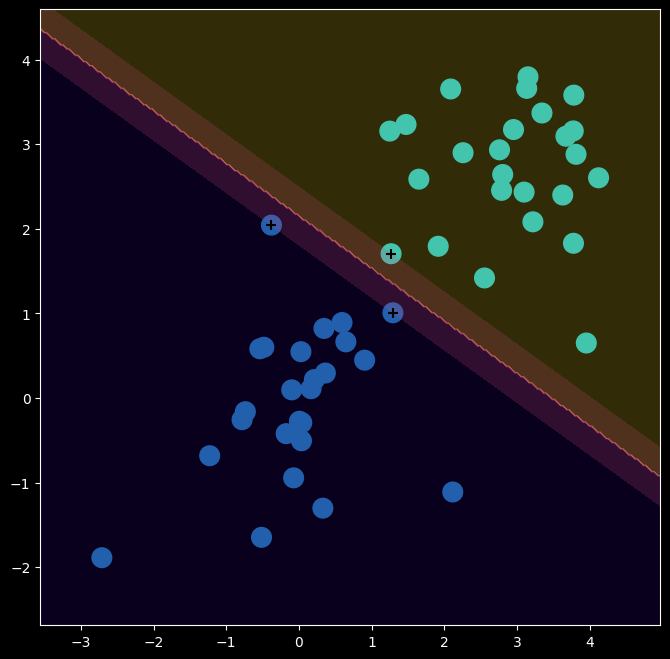

In [ ]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_, ax=ax)

실제로 훈련 오류는 발생하지 않았으며 단 3개의 서포트 벡터만 사용되었습니다. 사실, 큰 `C` 값은 이 세 개의 서포트 포인트가 *마진 위에* 있으며 마진을 정의한다는 것을 의미하기도 합니다. 단 3개의 데이터 포인트에만 의존하는 분류기가 테스트 데이터에서 얼마나 좋은 성능을 보일지 궁금할 수 있습니다! 이제 더 작은 `C` 값을 시도해 보겠습니다.

In [ ]:
svm_ = SVC(C=0.1, kernel="linear").fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


`C=0.1`을 사용하면 훈련 관측치를 잘못 분류하지 않으면서도 훨씬 더 넓은 마진을 얻고 12개의 서포트 벡터를 사용합니다. 이들은 결정 경계의 방향을 함께 정의하며, 그 수가 더 많기 때문에 더 안정적입니다. 이 모델이 `C=1e5`인 모델보다 테스트 데이터에서 더 나은 성능을 보일 가능성이 있어 보입니다(실제로 큰 테스트 세트를 사용한 간단한 실험으로 이를 확인할 수 있습니다).

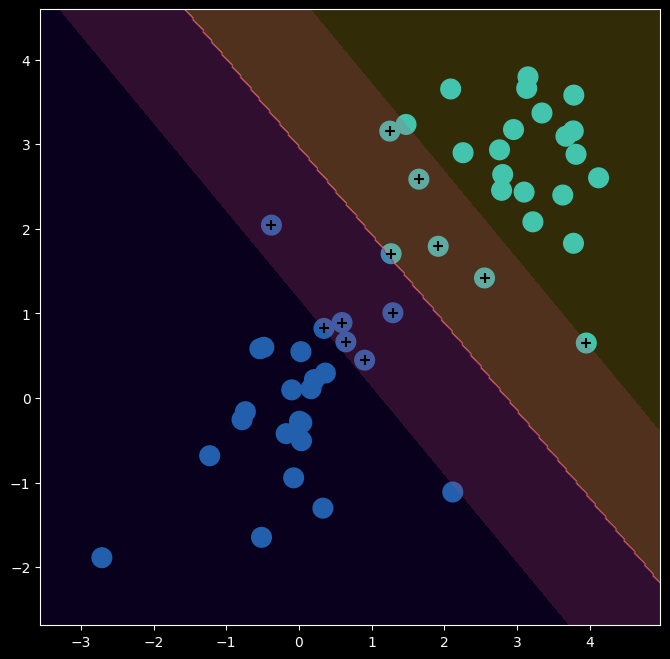

In [ ]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_, ax=ax)

## 서포트 벡터 머신
비선형 커널을 사용하여 SVM을 적합시키기 위해 다시 한번 `SVC()` 추정기를 사용합니다. 하지만 이제는 `kernel` 파라미터에 다른 값을 사용합니다. 다항식 커널로 SVM을 적합시키려면 `kernel="poly"`를 사용하고, 방사형 커널로 SVM을 적합시키려면 `kernel="rbf"`를 사용합니다. 전자의 경우 `degree` 인수를 사용하여 다항식 커널의 차수를 지정하고, 후자의 경우 `gamma`를 사용하여 방사 기저 커널 의 $\gamma$ 값을 지정합니다.

먼저 다음과 같이 비선형 클래스 경계를 가진 데이터를 생성합니다:

In [ ]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1] * 150 + [2] * 50)

데이터를 플롯해보면 클래스 경계가 실제로 비선형이라는 것이 명확해집니다.

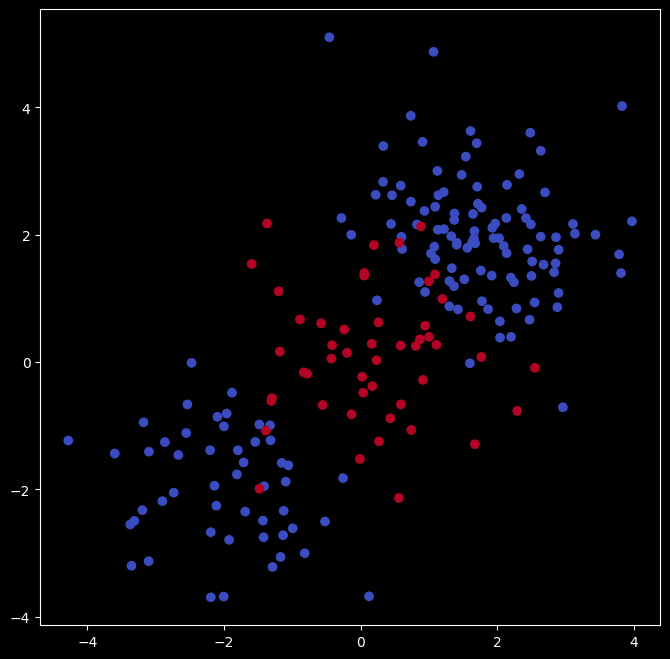

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm)

데이터는 훈련 그룹과 테스트 그룹으로 무작위로 분할됩니다. 그런 다음 방사형 커널과 $\gamma=1$을 사용하여 `SVC()` 추정기로 훈련 데이터를 적합시킵니다:

In [ ]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, y, test_size=0.5, random_state=0
)
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,1
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


플롯은 결과 SVM이 명확하게 비선형적인 경계를 가지고 있음을 보여줍니다.

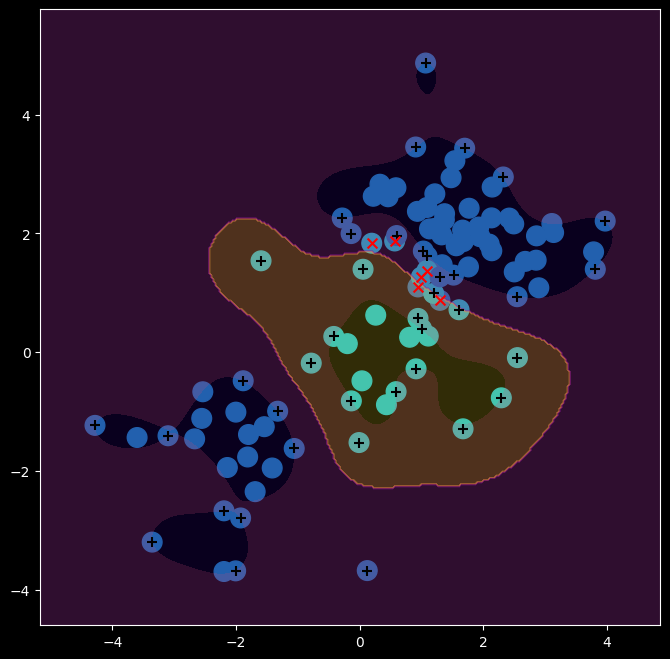

In [ ]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

그림에서 이 SVM 적합에 상당한 수의 훈련 오류가 있음을 알 수 있습니다. `C` 값을 높이면 훈련 오류의 수를 줄일 수 있습니다. 그러나 이는 데이터에 과적합될 위험이 있는 더 불규칙한 결정 경계를 대가로 합니다.

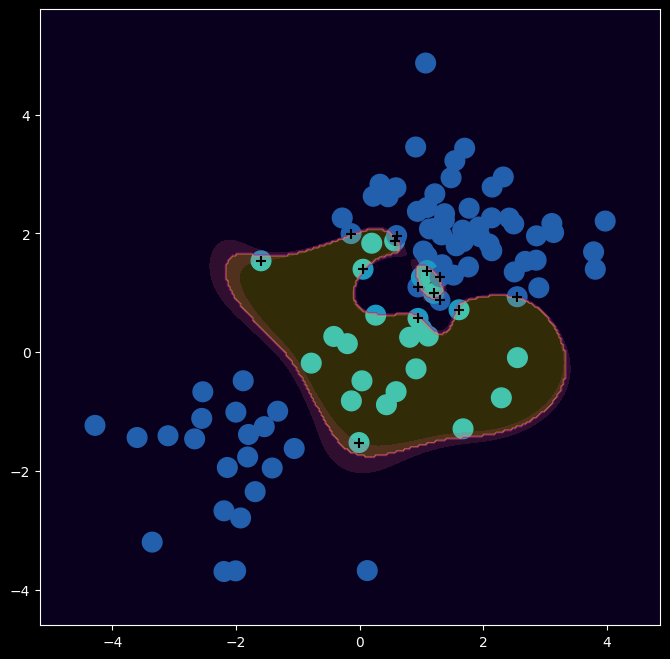

In [ ]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

`skm.GridSearchCV()`를 사용하여 교차 검증을 수행하여 방사형 커널을 사용하는 SVM에 대한 최적의 $\gamma$ 및 `C`를 선택할 수 있습니다:

In [ ]:
kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(
    svm_rbf,
    {"C": [0.1, 1, 10, 100, 1000], "gamma": [0.5, 1, 2, 3, 4]},
    refit=True,
    cv=kfold,
    scoring="accuracy",
)
grid.fit(X_train, y_train)
grid.best_params_

{'C': 1, 'gamma': 0.5}

5-겹 교차 검증 하에서 최적의 파라미터 선택은 `C=1`과 `gamma=0.5`에서 달성되지만, 다른 여러 값들도 동일한 값을 달성합니다.

Truth,1,2
Predicted,,
1,69,6
2,6,19


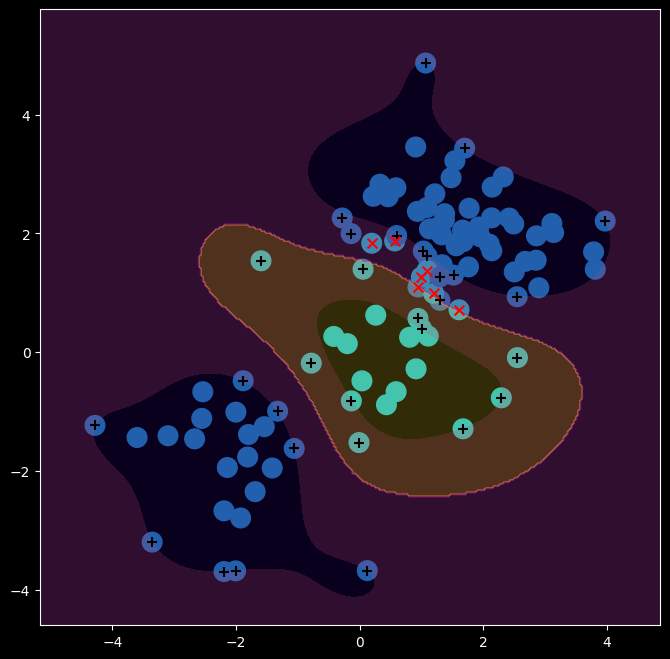

In [ ]:
best_svm = grid.best_estimator_
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train, y_train, best_svm, ax=ax)

y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)

이 파라미터들을 사용하면, 이 SVM에 의해 테스트 관측치의 12%가 잘못 분류됩니다.

## ROC 곡선

SVM과 서포트 벡터 분류기는 각 관측치에 대한 클래스 레이블을 출력합니다. 그러나 각 관측치에 대한 *적합값(fitted values)*을 얻는 것도 가능하며, 이는 클래스 레이블을 얻는 데 사용되는 수치적 점수입니다. 예를 들어, 서포트 벡터 분류기의 경우 관측치 $X= (X_1, X_2, \ldots, X_p)^T$에 대한 적합값은 $\hat{\beta}_0 + \hat{\beta}_1 X_1 + \hat{\beta}_2 X_2 + \ldots + \hat{\beta}_p X_p$ 형태를 가집니다. 비선형 커널을 사용하는 SVM의 경우, 적합값을 산출하는 방정식은 (\ref{Ch9:eq:svmip})에 나와 있습니다. 적합값의 부호는 관측치가 결정 경계의 어느 쪽에 있는지 결정합니다. 따라서 주어진 관측치에 대한 적합값과 클래스 예측 사이의 관계는 간단합니다. 적합값이 0을 초과하면 관측치는 한 클래스에 할당되고, 0보다 작으면 다른 클래스에 할당됩니다. 이 임계값을 0에서 양수 값으로 변경함으로써 한 클래스 대 다른 클래스에 유리하도록 분류를 편향시킬 수 있습니다. 양수 및 음수의 다양한 임계값을 고려하여 ROC 플롯의 구성 요소를 생성합니다. 적합된 SVM 추정기의 `decision_function()` 메서드를 호출하여 이러한 값에 접근할 수 있습니다.

`ROCCurveDisplay.from_estimator()` 함수(우리는 `roc_curve()`로 축약했습니다)는 ROC 곡선 플롯을 생성합니다. 첫 번째 인수로 적합된 추정기를 받고, 그 뒤에 모델 행렬 $X$와 레이블 $y$가 옵니다. `name` 인수는 범례에 사용되고, `color`는 선의 색상에 사용됩니다. 결과는 우리의 축 객체 `ax`에 플롯됩니다.

/Users/jeonghyeonyun/Projects/idas/.venv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


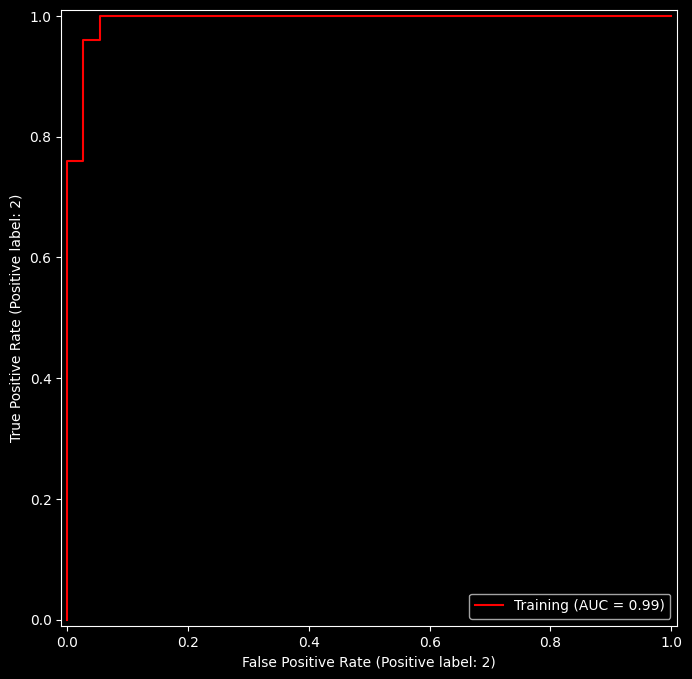

In [ ]:
fig, ax = subplots(figsize=(8, 8))
roc_curve(
    best_svm, X_train, y_train, name="Training", ax=ax, curve_kwargs={"color": "r"}
)

 이 예에서 SVM은 정확한 예측을 제공하는 것으로 보입니다. $\gamma$를 증가시켜 더 유연한 적합을 생성하고 정확도를 더욱 향상시킬 수 있습니다.

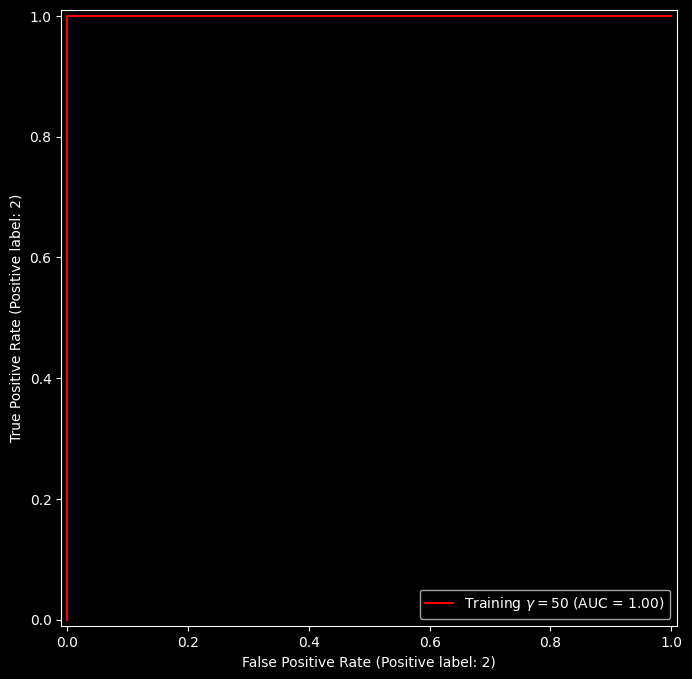

In [33]:
svm_flex = SVC(kernel="rbf", gamma=50, C=1)
svm_flex.fit(X_train, y_train)
fig, ax = subplots(figsize=(8, 8))
roc_curve(
    svm_flex,
    X_train,
    y_train,
    name="Training $\gamma=50$",
    ax=ax,
    curve_kwargs={"color": "r"},
)

그러나 이러한 ROC 곡선은 모두 훈련 데이터에 대한 것입니다. 우리는 실제로 테스트 데이터에 대한 예측 정확도 수준에 더 관심이 있습니다. 테스트 데이터에 대해 ROC 곡선을 계산할 때 $\gamma=0.5$인 모델이 가장 정확한 결과를 제공하는 것으로 보입니다.

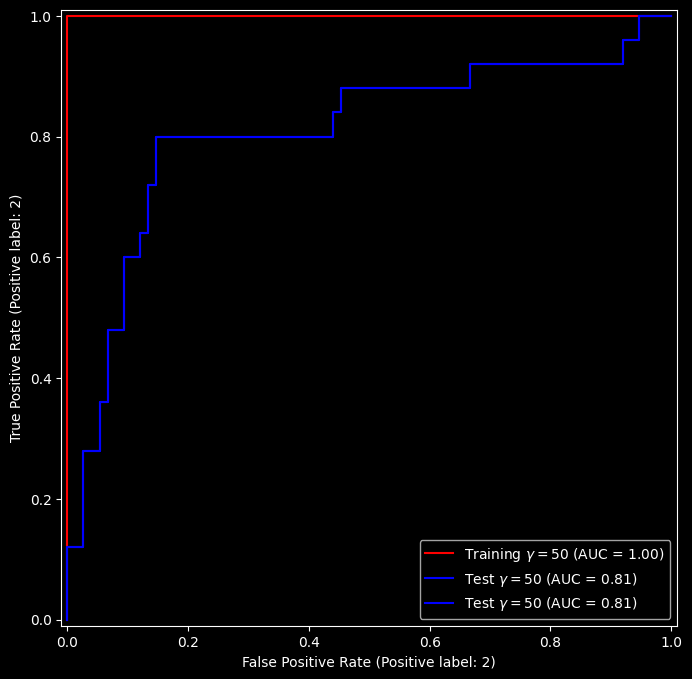

In [29]:
roc_curve(
    svm_flex,
    X_test,
    y_test,
    name="Test $\gamma=50$",
    ax=ax,
    curve_kwargs={"color": "b"},
)
fig

튜닝된 SVM을 살펴보겠습니다.

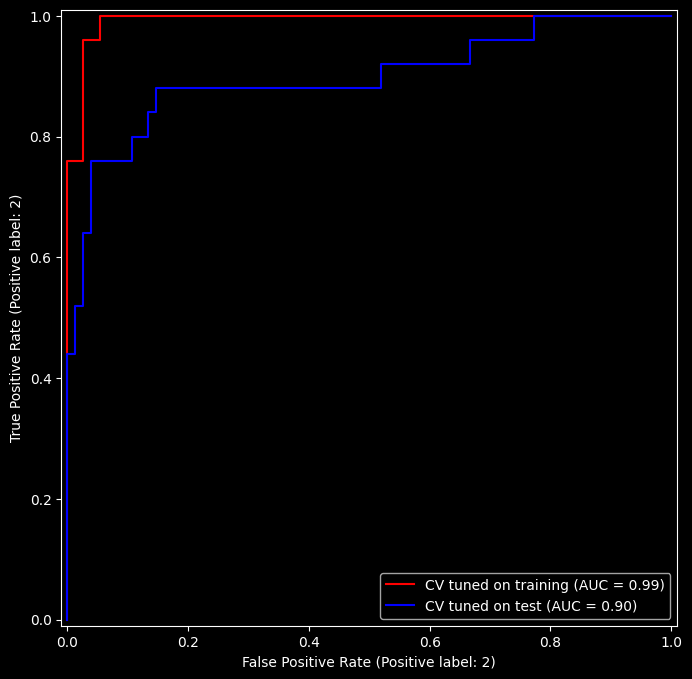

In [30]:
fig, ax = subplots(figsize=(8, 8))
for X_, y_, c, name in zip(
    (X_train, X_test),
    (y_train, y_test),
    ("r", "b"),
    ("CV tuned on training", "CV tuned on test"),
):
    roc_curve(best_svm, X_, y_, name=name, ax=ax, curve_kwargs={"color": c})

## 다중 클래스를 사용한 SVM

응답 변수가 두 개 이상의 레벨을 포함하는 요인인 경우, `SVC()` 함수는 일대일(one-versus-one) 접근법(`decision_function_shape=='ovo'`일 때) 또는 일대다(one-versus-rest){일대다는 일대모두(one-versus-all)라고도 알려져 있습니다.} 접근법(`decision_function_shape=='ovr'`일 때)을 사용하여 다중 클래스 분류를 수행합니다. 여기서는 세 번째 클래스의 관측치를 생성하여 해당 설정을 간략하게 탐색합니다.

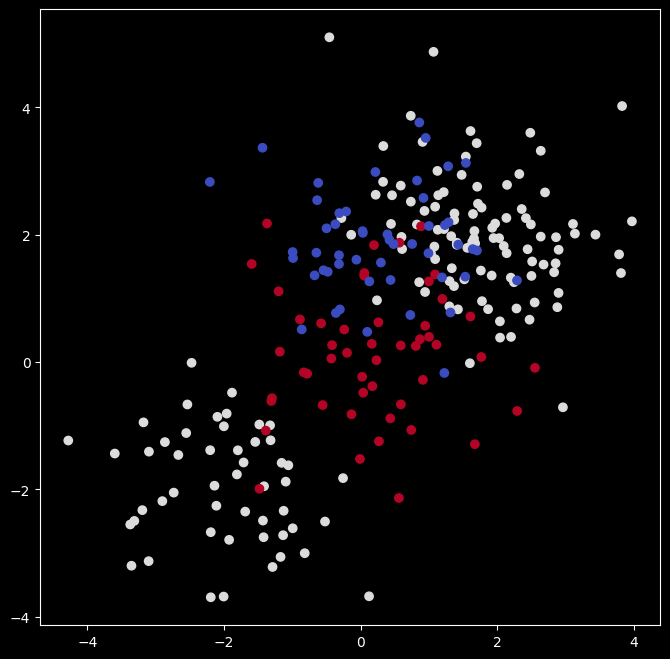

In [31]:
rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0] * 50])
X[y == 0, 1] += 2
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.coolwarm)

이제 데이터에 SVM을 적합시킵니다:

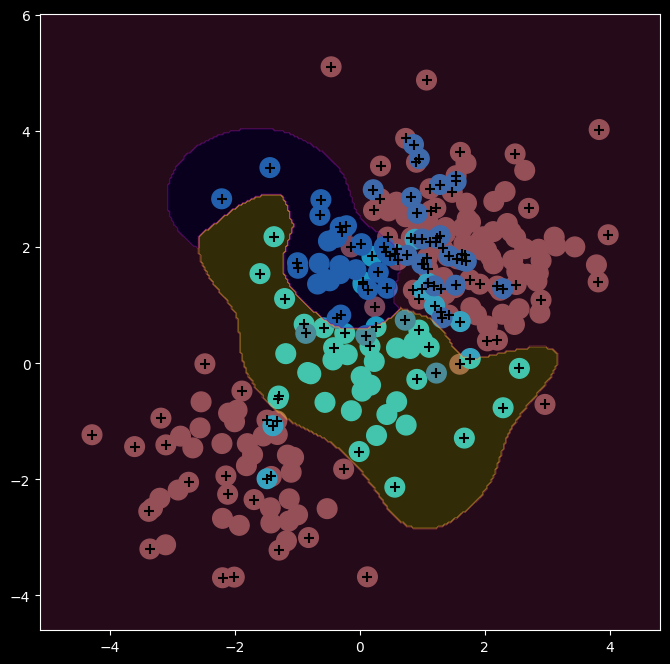

In [32]:
svm_rbf_3 = SVC(kernel="rbf", C=10, gamma=1, decision_function_shape="ovo")
svm_rbf_3.fit(X, y)
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_rbf_3, scatter_cmap=cm.tab10, ax=ax)